In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deap

In [3]:
!pip install bitstring

In [4]:
!pip install transforms3d

In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=2
n_out=7
nb_col=5

In [28]:
start_date = '2020-06-15'
end_date = '2020-08-01'
start_date2 = '2020-08-02'
end_date2 = '2020-08-15'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(48, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(48, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco
23038,539.0,9613.0,213.0,0.0,36910558.0,2020-06-20,Morocco
23039,188.0,9801.0,213.0,0.0,36910558.0,2020-06-21,Morocco
23040,176.0,9977.0,214.0,1.0,36910558.0,2020-06-22,Morocco
23041,195.0,10172.0,214.0,0.0,36910558.0,2020-06-23,Morocco
23042,92.0,10264.0,214.0,0.0,36910558.0,2020-06-24,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23071,220.0,17962.0,285.0,5.0,36910558.0,2020-07-23,Morocco
23072,302.0,18264.0,292.0,7.0,36910558.0,2020-07-24,Morocco
23073,570.0,18834.0,299.0,7.0,36910558.0,2020-07-25,Morocco
23074,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
23075,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(14, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
1,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco
2,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
3,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
4,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
5,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
6,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
7,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
8,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
9,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48, 5)
(48, 1)
(16, 5)
(16, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-2)  var2(t-2)  var3(t-2)  ...  var3(t+6)  var4(t+6)  var5(t+6)
2    0.039511   0.000000   0.000000  ...   0.014184   0.000000        0.0
3    0.097836   0.006672   0.000000  ...   0.014184   0.000000        0.0
4    0.078081   0.011996   0.000000  ...   0.028369   0.166667        0.0
5    0.071496   0.016872   0.007092  ...   0.035461   0.083333        0.0
6    0.072436   0.021812   0.007092  ...   0.042553   0.083333        0.0
7    0.507056   0.056390   0.007092  ...   0.056738   0.166667        0.0
8    0.176858   0.068450   0.007092  ...   0.063830   0.083333        0.0
9    0.165569   0.079741   0.014184  ...   0.092199   0.333333        0.0
10   0.183443   0.092250   0.014184  ...   0.113475   0.250000        0.0
11   0.086548   0.098152   0.014184  ...   0.113475   0.000000        0.0
12   0.604892   0.139402   0.028369  ...   0.120567   0.083333        0.0
13   0.405456   0.167052   0.035461  ...   0.127660   0.083333        0.0
14   0.277516   0.185976   0.042553  .

In [51]:
print(X_test)

   var1(t-2)  var2(t-2)  var3(t-2)  ...  var3(t+6)  var4(t+6)  var5(t+6)
2   0.536336   0.000000   0.000000  ...   0.433962   0.238095        0.0
3   0.553736   0.066512   0.026415  ...   0.505660   0.571429        0.0
4   0.175026   0.109874   0.079245  ...   0.573585   0.523810        0.0
5   0.000000   0.142535   0.135849  ...   0.641509   0.523810        0.0
6   0.140225   0.183769   0.207547  ...   0.705660   0.476190        0.0
7   0.510747   0.247654   0.267925  ...   0.792453   0.761905        0.0
8   0.778915   0.327931   0.335849  ...   0.898113   1.000000        0.0
9   0.636643   0.399512   0.388679  ...   1.000000   0.952381        0.0

[8 rows x 45 columns]


In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
2,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
3,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
4,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
5,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
6,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0
7,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
8,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
9,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0
10,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0
11,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713

In [54]:
Y_train.head(5)

,var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.039511,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443
3,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548
4,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456
6,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.039511,0.0,0.0,0.0,0.0,0.097836,0.006672,0.0,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(40, 7)
(8, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443
3,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548
4,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456
6,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(40, 10)
(8, 10)


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0
3,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0
4,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0
5,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0
6,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0
7,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0
8,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0
9,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
10,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
11,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0


In [66]:
X_test

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.536336,0.000000,0.000000,0.238095,0.0,0.553736,0.066512,0.026415,0.000000,0.0
3,0.553736,0.066512,0.026415,0.000000,0.0,0.175026,0.109874,0.079245,0.333333,0.0
4,0.175026,0.109874,0.079245,0.333333,0.0,0.000000,0.142535,0.135849,0.380952,0.0
5,0.000000,0.142535,0.135849,0.380952,0.0,0.140225,0.183769,0.207547,0.571429,0.0
6,0.140225,0.183769,0.207547,0.571429,0.0,0.510747,0.247654,0.267925,0.428571,0.0
7,0.510747,0.247654,0.267925,0.428571,0.0,0.778915,0.327931,0.335849,0.523810,0.0
8,0.778915,0.327931,0.335849,0.523810,0.0,0.636643,0.399512,0.388679,0.333333,0.0
9,0.636643,0.399512,0.388679,0.333333,0.0,0.507676,0.463209,0.433962,0.238095,0.0


In [67]:
print(X_test.shape)

(8, 10)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.536336,0.0,0.0,0.238095,0.0,0.553736,0.066512,0.026415,0.0,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(8, 1, 10) (8, 7) (40, 1, 10) (40, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(8, 1, 10) (8, 7) (40, 1, 10) (40, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [74]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7]], Y_test[[0,7]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  223 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0682 - val_loss: 0.1347
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1035
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1099
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1154
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1088
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1082
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1084
Epoch 8/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0931
Epoch 9/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1064
Epoch 10/1000
40/40 [==============================

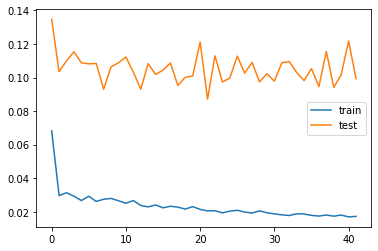

(40, 7)
(40, 7)
(40, 7)
score_train: [119.928] 119.1, 121.1, 132.5, 123.5, 107.6, 120.8, 113.4
(8, 1, 10)
score_test: [307.890] 361.1, 364.9, 33.7, 232.1, 458.5, 271.0, 247.7

RMSE test:  307.88963170228055 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0955
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.1083
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1040
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1025
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0866
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0976
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0985
Epoch 8/1000
40/40 [======================

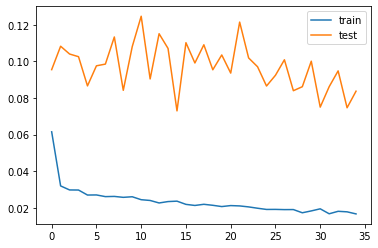

(40, 7)
(40, 7)
(40, 7)
score_train: [121.108] 118.8, 122.7, 130.5, 125.7, 110.1, 119.0, 119.8
(8, 1, 10)
score_test: [282.658] 343.0, 338.0, 9.5, 177.7, 439.1, 258.9, 189.2

RMSE test:  282.65783823032694 


Units CNN1:  253 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0604 - val_loss: 0.1037
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.1001
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1008
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0974
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1035
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.1171
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0919
Epoch 8/1000
40/40 [=======================

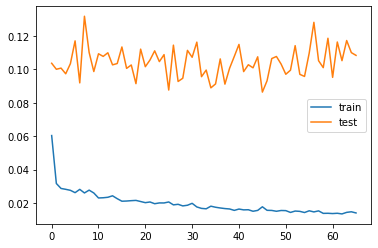

(40, 7)
(40, 7)
(40, 7)
score_train: [105.312] 98.8, 98.7, 116.7, 110.2, 95.1, 110.4, 105.4
(8, 1, 10)
score_test: [321.715] 344.0, 436.6, 68.1, 263.2, 438.0, 298.8, 246.1

RMSE test:  321.7154282153795 


Units CNN1:  246 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.1033
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.1038
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0873
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1016
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1035
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0946
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1019
Epoch 8/1000
40/40 [==========================

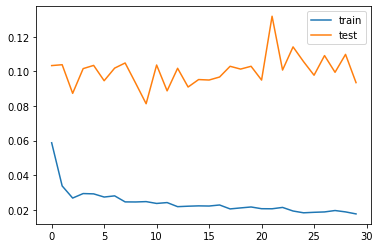

(40, 7)
(40, 7)
(40, 7)
score_train: [124.202] 123.4, 126.2, 133.5, 128.7, 113.8, 122.8, 120.0
(8, 1, 10)
score_test: [298.728] 341.3, 358.3, 53.1, 189.2, 451.8, 293.4, 225.7

RMSE test:  298.72770338259016 


Units CNN1:  251 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0891
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0902
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0952
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0946
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0925
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0904
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0867
Epoch 8/1000
40/40 [======================

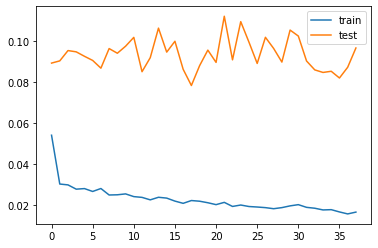

(40, 7)
(40, 7)
(40, 7)
score_train: [118.041] 118.5, 119.0, 126.5, 122.6, 106.2, 117.0, 115.3
(8, 1, 10)
score_test: [303.496] 355.2, 366.5, 77.2, 270.7, 410.9, 296.1, 220.4

RMSE test:  303.4964760749392 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0899
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.1069
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1051
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0835
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1131
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1128
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0963
Epoch 8/1000
40/40 [=======================

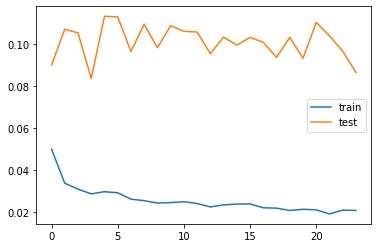

(40, 7)
(40, 7)
(40, 7)
score_train: [132.945] 134.7, 143.3, 140.6, 132.2, 119.9, 129.1, 129.5
(8, 1, 10)
score_test: [287.187] 341.5, 328.8, 59.9, 192.7, 428.6, 275.0, 229.2

RMSE test:  287.18735752568136 


Units CNN1:  253 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0573 - val_loss: 0.1039
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0890
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0925
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0840
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0913
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0950
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0962
Epoch 8/1000
40/40 [======================

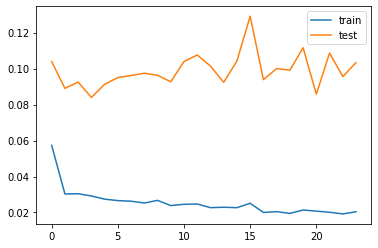

(40, 7)
(40, 7)
(40, 7)
score_train: [128.583] 131.4, 134.1, 133.8, 126.6, 117.4, 126.9, 129.0
(8, 1, 10)
score_test: [314.060] 370.0, 353.4, 32.8, 229.9, 444.3, 340.6, 247.6

RMSE test:  314.0601992051687 


Units CNN1:  253 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0560 - val_loss: 0.1019
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.1037
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1079
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0962
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1012
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1029
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0999
Epoch 8/1000
40/40 [=======================

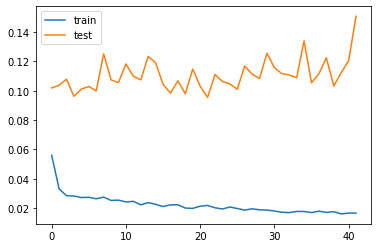

(40, 7)
(40, 7)
(40, 7)
score_train: [130.363] 126.9, 123.9, 130.8, 130.3, 124.5, 137.8, 137.6
(8, 1, 10)
score_test: [379.444] 411.1, 413.8, 106.8, 301.8, 543.2, 385.7, 348.3

RMSE test:  379.4438529957673 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.1093
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1081
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0938
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1048
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0900
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0992
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0922
Epoch 8/1000
40/40 [======================

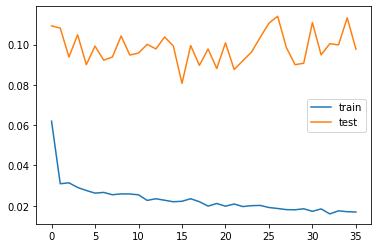

(40, 7)
(40, 7)
(40, 7)
score_train: [117.095] 114.8, 116.4, 127.1, 120.5, 107.3, 115.5, 117.2
(8, 1, 10)
score_test: [305.433] 350.3, 369.3, 45.5, 236.5, 432.7, 297.9, 245.0

RMSE test:  305.43344734137986 


Units CNN1:  251 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0974
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1065
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0945
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1219
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1081
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1102
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.1137
Epoch 8/1000
40/40 [======================

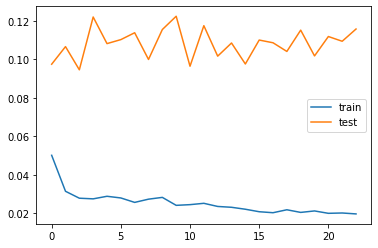

(40, 7)
(40, 7)
(40, 7)
score_train: [129.674] 130.2, 132.3, 137.5, 130.8, 119.0, 128.7, 128.4
(8, 1, 10)
score_test: [332.303] 380.5, 365.7, 43.7, 265.2, 498.7, 331.4, 252.3

RMSE test:  332.3033531818561 

gen	nevals	avg    	std    	min    	max   
0  	10    	285.181	7.56954	282.658	307.89

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0985
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0909
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1088
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0969
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1149
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1061
Epoch 7/1000
40/40 [==============================] - 0s 1m

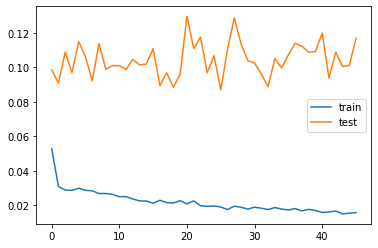

(40, 7)
(40, 7)
(40, 7)
score_train: [114.207] 113.4, 112.7, 125.1, 117.6, 107.2, 115.1, 107.4
(8, 1, 10)
score_test: [334.055] 334.2, 380.8, 34.3, 281.9, 485.3, 370.0, 267.2

RMSE test:  334.0547852331048 


Units CNN1:  159 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0686 - val_loss: 0.1577
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1059
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1060
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1132
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.1085
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1162
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1022
Epoch 8/1000
40/40 [=======================

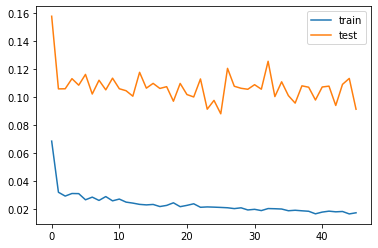

(40, 7)
(40, 7)
(40, 7)
score_train: [121.149] 122.6, 121.7, 129.0, 123.8, 112.1, 119.8, 118.4
(8, 1, 10)
score_test: [295.350] 350.0, 355.7, 38.5, 205.1, 432.1, 277.1, 233.6

RMSE test:  295.3497680000246 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0778
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0974
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0791
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0930
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1054
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0979
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0926
Epoch 8/1000
40/40 [=======================

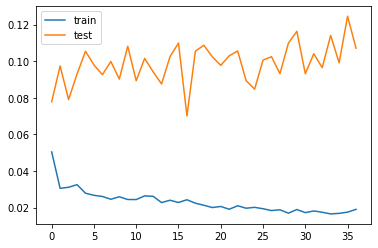

(40, 7)
(40, 7)
(40, 7)
score_train: [121.637] 119.7, 121.1, 131.3, 128.1, 114.0, 120.8, 115.5
(8, 1, 10)
score_test: [319.737] 356.3, 361.5, 68.3, 291.7, 471.4, 297.7, 239.6

RMSE test:  319.7371648640174 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0792
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1137
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0975
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.1058
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1067
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1130
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0935
Epoch 8/1000
40/40 [=======================

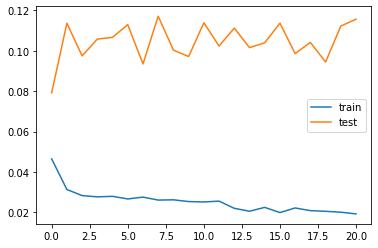

(40, 7)
(40, 7)
(40, 7)
score_train: [132.474] 131.2, 137.5, 139.9, 126.9, 117.3, 130.3, 142.5
(8, 1, 10)
score_test: [332.250] 377.8, 348.9, 59.0, 229.2, 479.0, 331.9, 335.6

RMSE test:  332.2501034569757 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.0588 - val_loss: 0.1202
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1112
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1264
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1021
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.1027
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.1092
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1115
Epoch 8/1000
40/40 [======================

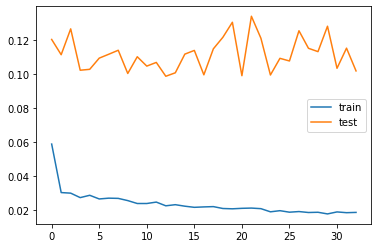

(40, 7)
(40, 7)
(40, 7)
score_train: [122.149] 124.7, 123.3, 129.6, 125.4, 111.7, 118.9, 120.5
(8, 1, 10)
score_test: [311.624] 358.1, 365.2, 31.7, 264.3, 453.5, 298.2, 229.5

RMSE test:  311.62417252700203 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0723 - val_loss: 0.1249
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1104
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1012
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1229
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1167
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0983
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0907
Epoch 8/1000
40/40 [======================

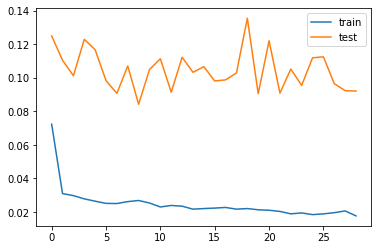

(40, 7)
(40, 7)
(40, 7)
score_train: [125.574] 125.6, 129.3, 134.6, 125.9, 114.9, 125.5, 122.3
(8, 1, 10)
score_test: [296.413] 348.0, 369.5, 55.0, 222.8, 431.2, 256.4, 230.2

RMSE test:  296.4129749767993 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0929
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0996
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1169
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0826
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0913
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0944
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0979
Epoch 8/1000
40/40 [=======================

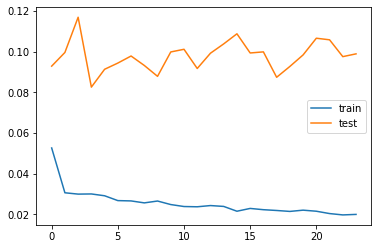

(40, 7)
(40, 7)
(40, 7)
score_train: [129.909] 131.1, 133.1, 135.4, 129.1, 118.0, 129.7, 132.2
(8, 1, 10)
score_test: [307.272] 328.3, 363.8, 59.5, 237.0, 427.3, 318.2, 277.9

RMSE test:  307.271690118971 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0947
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0958
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1003
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0836
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1138
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1027
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.1070
Epoch 8/1000
40/40 [========================

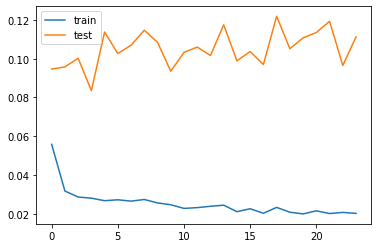

(40, 7)
(40, 7)
(40, 7)
score_train: [128.666] 130.1, 131.9, 134.8, 127.3, 119.9, 127.9, 128.2
(8, 1, 10)
score_test: [325.896] 369.1, 373.6, 58.1, 274.9, 462.5, 320.9, 268.0

RMSE test:  325.89565544198877 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0713 - val_loss: 0.1061
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0849
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0907
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0869
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0971
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1011
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0973
Epoch 8/1000
40/40 [======================

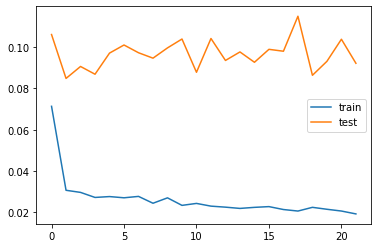

(40, 7)
(40, 7)
(40, 7)
score_train: [131.263] 131.5, 135.8, 137.2, 128.5, 121.1, 129.3, 134.6
(8, 1, 10)
score_test: [296.658] 341.3, 347.4, 32.1, 230.7, 440.4, 293.4, 211.2

RMSE test:  296.65788599875634 

1  	9     	285.181	7.56954	282.658	307.89

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0583 - val_loss: 0.0853
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0968
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0938
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0922
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0901
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1057
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0922


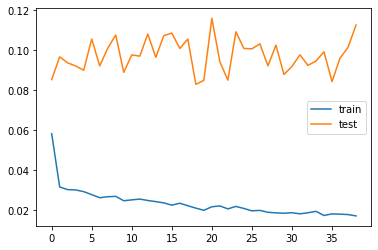

(40, 7)
(40, 7)
(40, 7)
score_train: [124.154] 122.1, 125.6, 131.7, 124.9, 112.5, 126.1, 125.4
(8, 1, 10)
score_test: [327.967] 354.4, 369.9, 43.2, 272.9, 464.9, 341.7, 285.0

RMSE test:  327.9670089123774 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.1037
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1027
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1066
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1003
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1108
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0956
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1048
Epoch 8/1000
40/40 [=======================

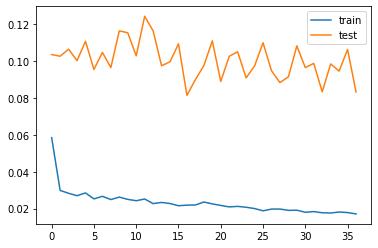

(40, 7)
(40, 7)
(40, 7)
score_train: [121.545] 119.4, 125.1, 134.2, 125.2, 111.4, 119.1, 114.9
(8, 1, 10)
score_test: [282.032] 326.8, 332.0, 32.4, 195.4, 414.1, 265.7, 241.7

RMSE test:  282.0316792418481 


Units CNN1:  247 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.1053
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0949
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0995
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1081
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0952
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1043
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1061
Epoch 8/1000
40/40 [=======================

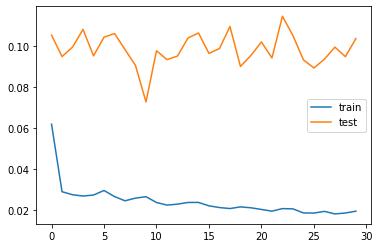

(40, 7)
(40, 7)
(40, 7)
score_train: [126.439] 127.0, 129.1, 135.1, 126.5, 116.2, 124.2, 126.2
(8, 1, 10)
score_test: [314.560] 343.2, 335.7, 48.0, 245.2, 476.1, 317.8, 268.5

RMSE test:  314.55952648700185 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0840
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1032
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0914
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0922
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0807
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0900
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0929
Epoch 8/1000
40/40 [======================

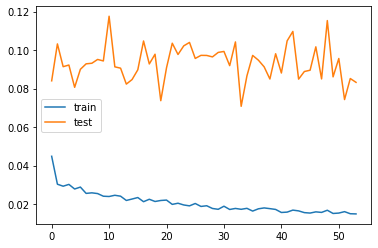

(40, 7)
(40, 7)
(40, 7)
score_train: [111.964] 108.4, 111.3, 122.8, 116.7, 103.1, 110.9, 109.5
(8, 1, 10)
score_test: [281.892] 303.4, 364.5, 45.9, 249.1, 364.9, 297.8, 213.0

RMSE test:  281.8915772429777 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0945
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0988
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.1152
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1050
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.1004
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1262
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1107
Epoch 8/1000
40/40 [=======================

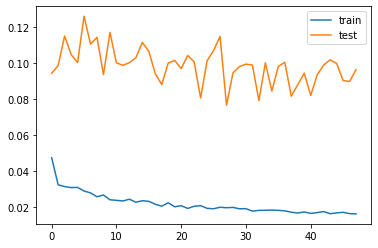

(40, 7)
(40, 7)
(40, 7)
score_train: [116.119] 114.0, 120.5, 127.0, 121.2, 104.7, 112.7, 111.5
(8, 1, 10)
score_test: [303.500] 320.3, 367.0, 52.7, 253.4, 429.6, 293.7, 264.0

RMSE test:  303.50022174412635 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0904
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0966
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0994
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1082
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0952
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0995
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1086
Epoch 8/1000
40/40 [======================

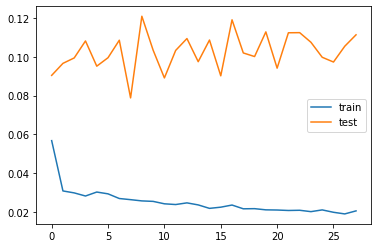

(40, 7)
(40, 7)
(40, 7)
score_train: [128.275] 129.7, 133.6, 135.1, 129.9, 115.7, 127.2, 125.9
(8, 1, 10)
score_test: [325.992] 375.6, 352.9, 47.3, 273.2, 471.3, 327.2, 268.6

RMSE test:  325.99154359954923 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.1039
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1055
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1262
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1046
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1112
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1018
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1171
Epoch 8/1000
40/40 [======================

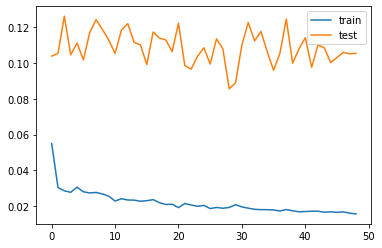

(40, 7)
(40, 7)
(40, 7)
score_train: [115.569] 114.2, 114.4, 125.3, 124.1, 105.6, 114.1, 109.9
(8, 1, 10)
score_test: [317.331] 345.6, 389.8, 43.2, 286.6, 446.1, 314.6, 226.8

RMSE test:  317.3307128484789 

2  	7     	284.749	7.72033	281.892	307.89

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.1002
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0935
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1200
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0858
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0944
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0982
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0969
E

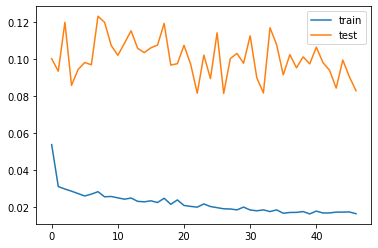

(40, 7)
(40, 7)
(40, 7)
score_train: [117.673] 115.0, 114.0, 126.6, 117.9, 106.7, 123.2, 119.1
(8, 1, 10)
score_test: [281.295] 346.1, 380.7, 21.7, 217.8, 383.7, 237.5, 194.1

RMSE test:  281.2948512225508 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0536 - val_loss: 0.1067
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0988
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0908
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1016
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1110
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1118
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0960
Epoch 8/1000
40/40 [=======================

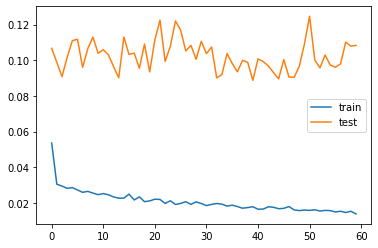

(40, 7)
(40, 7)
(40, 7)
score_train: [110.879] 108.5, 107.7, 122.5, 116.0, 101.4, 112.5, 106.4
(8, 1, 10)
score_test: [321.590] 326.2, 382.6, 46.8, 280.1, 459.8, 348.7, 239.9

RMSE test:  321.5904737967793 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0583 - val_loss: 0.0953
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1037
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1165
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0926
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1122
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0991
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.1143
Epoch 8/1000
40/40 [=======================

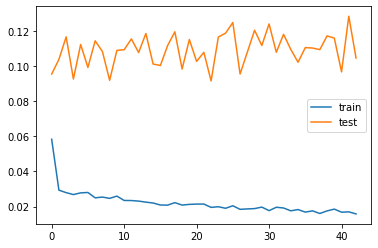

(40, 7)
(40, 7)
(40, 7)
score_train: [116.855] 115.3, 118.2, 127.2, 119.6, 107.4, 117.3, 112.0
(8, 1, 10)
score_test: [315.833] 338.4, 357.4, 67.5, 251.2, 497.0, 280.7, 250.2

RMSE test:  315.83317225311214 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.0477 - val_loss: 0.0806
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0942
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0901
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0903
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0981
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0960
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0825
Epoch 8/1000
40/40 [=====================

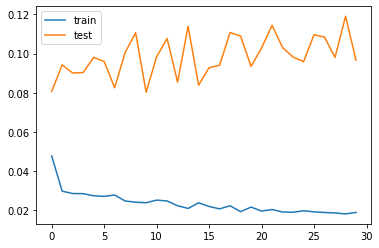

(40, 7)
(40, 7)
(40, 7)
score_train: [122.956] 122.7, 125.0, 132.5, 124.2, 113.9, 121.3, 120.4
(8, 1, 10)
score_test: [303.655] 345.5, 356.0, 49.1, 234.9, 440.7, 290.9, 250.9

RMSE test:  303.65489482874085 


Units CNN1:  223 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0892
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.1012
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0878
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0949
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0944
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0876
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1057
Epoch 8/1000
40/40 [======================

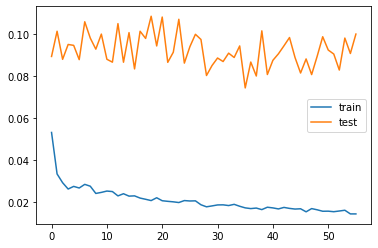

(40, 7)
(40, 7)
(40, 7)
score_train: [110.454] 106.9, 107.8, 120.5, 117.9, 100.9, 110.7, 107.2
(8, 1, 10)
score_test: [308.682] 326.3, 388.3, 41.9, 265.0, 440.9, 296.9, 235.0

RMSE test:  308.6815596758606 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0760
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0940
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0764
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0915
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0862
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1016
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0892
Epoch 8/1000
40/40 [=======================

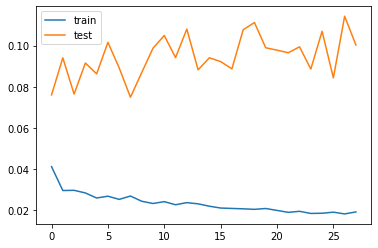

(40, 7)
(40, 7)
(40, 7)
score_train: [123.338] 123.7, 125.9, 132.1, 124.2, 113.4, 121.9, 121.4
(8, 1, 10)
score_test: [309.361] 343.2, 366.2, 54.4, 247.3, 453.7, 314.5, 221.7

RMSE test:  309.36106807217055 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.1080
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1116
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1086
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1035
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1069
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0930
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1041
Epoch 8/1000
40/40 [======================

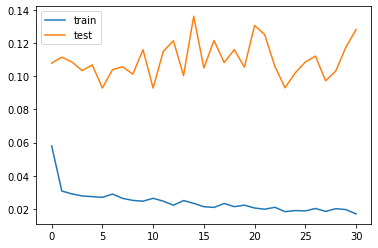

(40, 7)
(40, 7)
(40, 7)
score_train: [127.061] 126.7, 125.0, 135.4, 132.9, 121.0, 127.4, 120.3
(8, 1, 10)
score_test: [349.968] 367.6, 366.4, 75.8, 294.2, 516.6, 354.5, 321.2

RMSE test:  349.9680790630275 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0489 - val_loss: 0.0841
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0919
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0979
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0935
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0953
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0986
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.1034
Epoch 8/1000
40/40 [=======================

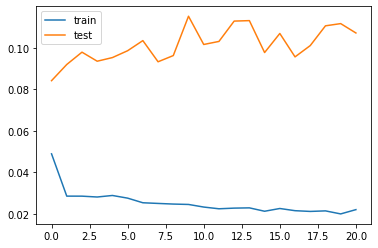

(40, 7)
(40, 7)
(40, 7)
score_train: [130.857] 132.2, 135.8, 135.8, 127.6, 120.4, 134.1, 129.4
(8, 1, 10)
score_test: [319.711] 346.6, 357.9, 54.5, 239.5, 493.2, 332.7, 230.3

RMSE test:  319.7110805432478 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0981
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0959
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1115
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1006
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0840
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1245
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1039
Epoch 8/1000
40/40 [=======================

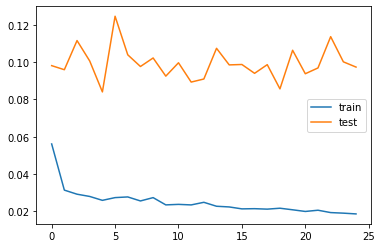

(40, 7)
(40, 7)
(40, 7)
score_train: [126.338] 124.7, 128.9, 138.6, 127.3, 116.3, 122.8, 124.6
(8, 1, 10)
score_test: [304.793] 346.6, 373.8, 45.4, 223.9, 435.7, 298.0, 244.1

RMSE test:  304.79254801961685 

3  	9     	281.431	0.408896	281.295	282.658

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.1047
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1122
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1126
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1082
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1077
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1009
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.106

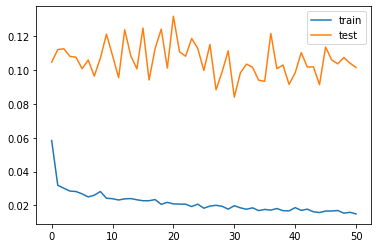

(40, 7)
(40, 7)
(40, 7)
score_train: [113.935] 110.6, 114.7, 125.6, 117.5, 104.3, 114.2, 109.5
(8, 1, 10)
score_test: [311.391] 341.6, 399.4, 61.7, 281.4, 414.3, 299.0, 241.9

RMSE test:  311.390899176559 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0605 - val_loss: 0.1173
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1077
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.1039
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1038
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1060
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0983
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1135
Epoch 8/1000
40/40 [========================

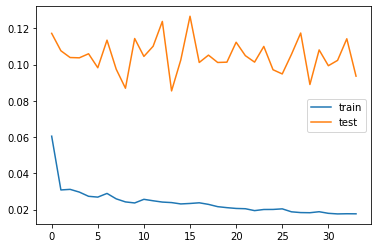

(40, 7)
(40, 7)
(40, 7)
score_train: [123.785] 126.7, 123.1, 131.2, 124.1, 114.0, 121.2, 125.4
(8, 1, 10)
score_test: [298.970] 376.9, 359.7, 42.5, 226.7, 419.7, 284.0, 210.4

RMSE test:  298.9701725711223 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.0585 - val_loss: 0.1069
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.1193
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1097
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1019
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0984
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1055
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1102
Epoch 8/1000
40/40 [======================

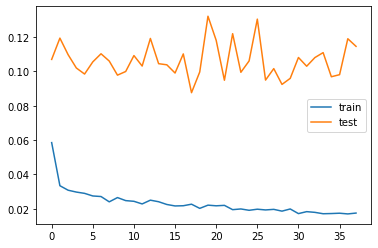

(40, 7)
(40, 7)
(40, 7)
score_train: [119.408] 117.6, 119.8, 128.9, 122.6, 110.7, 119.1, 116.4
(8, 1, 10)
score_test: [330.652] 380.7, 383.8, 58.6, 252.4, 471.7, 324.7, 279.4

RMSE test:  330.65217333997845 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0756
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0951
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1225
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0891
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0988
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1091
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0907
Epoch 8/1000
40/40 [======================

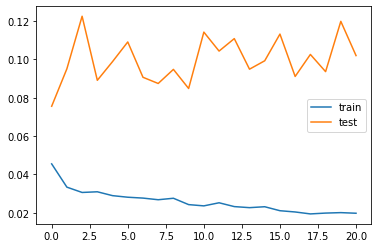

(40, 7)
(40, 7)
(40, 7)
score_train: [129.906] 130.5, 134.2, 136.8, 127.4, 120.0, 128.9, 131.0
(8, 1, 10)
score_test: [311.993] 357.0, 343.8, 37.7, 225.9, 459.5, 326.0, 256.7

RMSE test:  311.9932473865483 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0611 - val_loss: 0.0840
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0993
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0863
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0979
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0971
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0851
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0895
Epoch 8/1000
40/40 [=======================

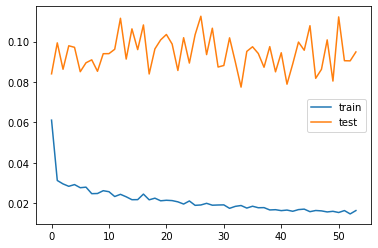

(40, 7)
(40, 7)
(40, 7)
score_train: [112.653] 110.8, 110.3, 122.8, 116.3, 105.7, 112.1, 109.8
(8, 1, 10)
score_test: [300.884] 351.9, 364.3, 52.4, 228.2, 407.3, 289.9, 269.0

RMSE test:  300.8838923073783 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0724
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0904
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1025
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1109
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0774
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1075
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0928
Epoch 8/1000
40/40 [=======================

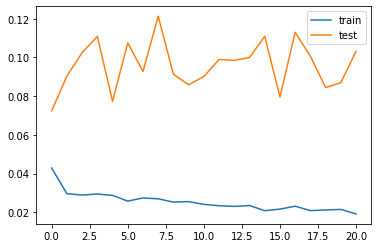

(40, 7)
(40, 7)
(40, 7)
score_train: [131.061] 132.1, 135.5, 138.2, 129.9, 120.4, 129.2, 131.4
(8, 1, 10)
score_test: [313.749] 334.8, 329.4, 78.0, 236.0, 490.0, 304.6, 271.7

RMSE test:  313.7493955602582 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0710 - val_loss: 0.1276
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0834
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1001
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1004
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1120
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0932
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0928
Epoch 8/1000
40/40 [=======================

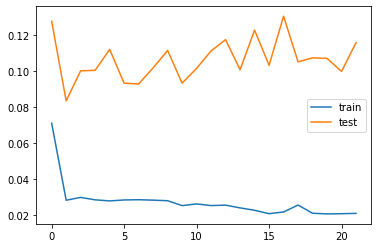

(40, 7)
(40, 7)
(40, 7)
score_train: [133.140] 132.5, 136.3, 138.2, 130.1, 124.4, 134.6, 135.4
(8, 1, 10)
score_test: [332.397] 353.9, 359.2, 45.6, 282.1, 500.8, 333.1, 275.3

RMSE test:  332.3966648967312 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0658 - val_loss: 0.1256
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.1114
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1067
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.1132
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0831
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0951
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0980
Epoch 8/1000
40/40 [=======================

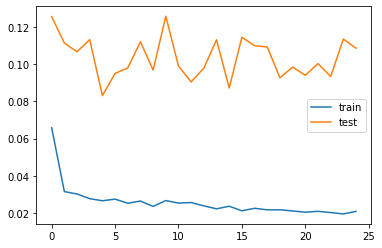

(40, 7)
(40, 7)
(40, 7)
score_train: [129.090] 134.2, 133.7, 137.1, 125.7, 117.7, 127.4, 126.9
(8, 1, 10)
score_test: [322.018] 391.7, 347.5, 40.1, 220.6, 462.7, 346.5, 259.4

RMSE test:  322.01750757338624 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0881
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0864
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0947
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1056
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0995
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0884
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0974
Epoch 8/1000
40/40 [======================

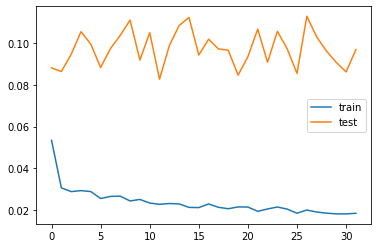

(40, 7)
(40, 7)
(40, 7)
score_train: [122.597] 124.6, 125.3, 131.7, 123.5, 112.3, 120.8, 119.1
(8, 1, 10)
score_test: [304.179] 355.8, 356.5, 58.9, 210.8, 453.6, 300.2, 224.0

RMSE test:  304.17929308274773 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0648 - val_loss: 0.1192
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1107
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0933
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0856
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0887
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1124
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1081
Epoch 8/1000
40/40 [======================

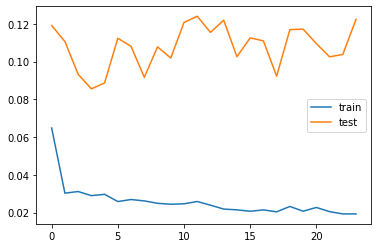

(40, 7)
(40, 7)
(40, 7)
score_train: [131.834] 128.6, 132.4, 136.9, 131.7, 121.9, 129.8, 140.8
(8, 1, 10)
score_test: [341.857] 372.5, 362.6, 36.0, 274.1, 486.1, 333.4, 352.1

RMSE test:  341.8573874190758 

4  	10    	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.0545 - val_loss: 0.1044
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1100
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1022
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0884
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1184
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1027
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.096

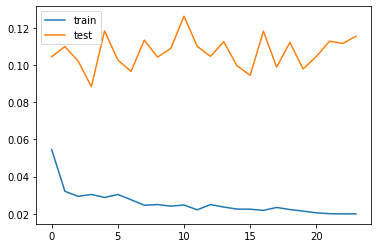

(40, 7)
(40, 7)
(40, 7)
score_train: [130.694] 133.5, 138.8, 136.6, 128.9, 119.8, 128.4, 128.1
(8, 1, 10)
score_test: [332.065] 386.5, 382.1, 30.4, 257.4, 496.4, 299.1, 271.0

RMSE test:  332.0654438281871 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0963
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1001
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1005
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1006
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1077
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0898
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.1176
Epoch 8/1000
40/40 [=======================

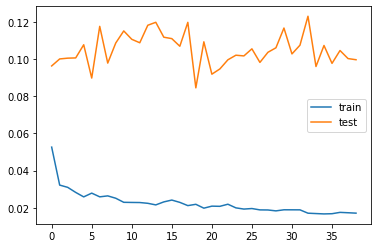

(40, 7)
(40, 7)
(40, 7)
score_train: [118.246] 117.2, 118.0, 125.8, 125.5, 106.9, 117.4, 115.8
(8, 1, 10)
score_test: [308.396] 358.3, 366.3, 52.7, 218.6, 446.5, 281.1, 272.5

RMSE test:  308.39557580764824 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0609 - val_loss: 0.1015
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1146
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1127
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0944
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0954
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1095
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0994
Epoch 8/1000
40/40 [======================

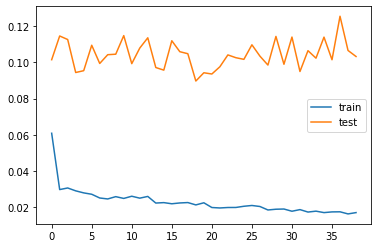

(40, 7)
(40, 7)
(40, 7)
score_train: [118.499] 117.0, 119.2, 129.8, 122.5, 109.4, 115.1, 115.5
(8, 1, 10)
score_test: [313.983] 344.0, 381.6, 29.1, 234.8, 449.6, 289.8, 289.9

RMSE test:  313.9830023336668 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0520 - val_loss: 0.1025
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0997
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1032
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1049
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.1041
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1273
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0929
Epoch 8/1000
40/40 [=======================

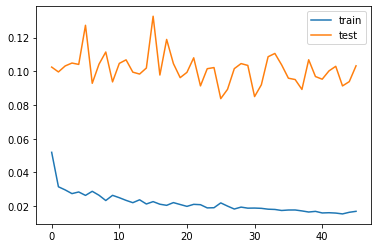

(40, 7)
(40, 7)
(40, 7)
score_train: [115.369] 114.5, 111.6, 127.0, 120.3, 108.3, 115.4, 109.5
(8, 1, 10)
score_test: [313.989] 349.3, 368.8, 32.8, 231.6, 469.1, 312.9, 243.8

RMSE test:  313.98898347523414 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0963
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1006
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0968
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1066
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1149
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0924
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.1032
Epoch 8/1000
40/40 [======================

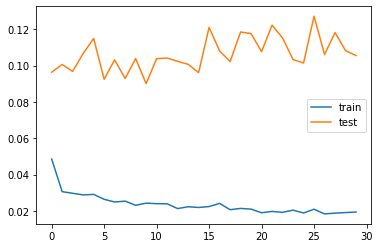

(40, 7)
(40, 7)
(40, 7)
score_train: [124.435] 124.6, 128.4, 131.9, 125.8, 117.4, 119.7, 122.6
(8, 1, 10)
score_test: [317.293] 356.2, 336.8, 41.1, 242.8, 469.8, 299.8, 305.4

RMSE test:  317.29258236419474 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0664 - val_loss: 0.1076
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.1019
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0835
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0946
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1108
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0971
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0932
Epoch 8/1000
40/40 [======================

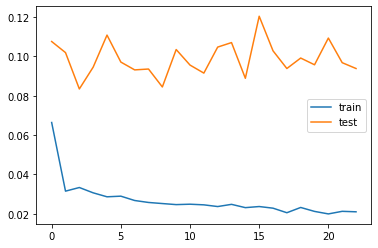

(40, 7)
(40, 7)
(40, 7)
score_train: [130.451] 129.1, 133.6, 138.2, 130.1, 120.6, 128.1, 132.7
(8, 1, 10)
score_test: [299.307] 347.0, 366.5, 51.4, 246.4, 416.0, 281.1, 238.5

RMSE test:  299.30688890086435 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.1131
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1105
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1124
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1048
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1103
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1174
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1017
Epoch 8/1000
40/40 [======================

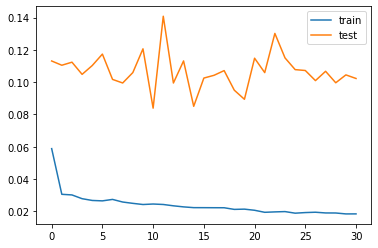

(40, 7)
(40, 7)
(40, 7)
score_train: [122.930] 120.6, 125.6, 134.4, 124.3, 112.6, 120.6, 121.3
(8, 1, 10)
score_test: [312.481] 359.6, 337.0, 38.0, 266.6, 463.0, 306.0, 245.0

RMSE test:  312.4805734713861 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.1022
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0891
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1020
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1167
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1133
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1007
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.1137
Epoch 8/1000
40/40 [=======================

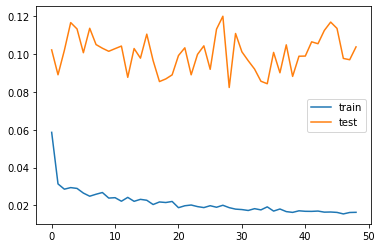

(40, 7)
(40, 7)
(40, 7)
score_train: [113.946] 113.2, 113.1, 124.3, 118.8, 103.9, 114.1, 109.1
(8, 1, 10)
score_test: [314.801] 358.1, 389.9, 69.7, 209.0, 437.9, 311.3, 276.2

RMSE test:  314.80117598096615 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.0516 - val_loss: 0.0902
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0989
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0938
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1050
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0821
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1305
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0957
Epoch 8/1000
40/40 [=====================

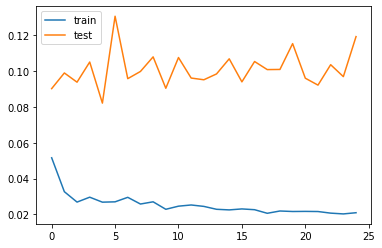

(40, 7)
(40, 7)
(40, 7)
score_train: [130.649] 129.2, 134.3, 138.8, 130.0, 123.5, 128.2, 130.1
(8, 1, 10)
score_test: [337.273] 359.0, 367.5, 66.2, 263.4, 497.3, 358.1, 288.2

RMSE test:  337.2733560145755 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0662 - val_loss: 0.1028
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0867
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0974
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1077
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0949
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1007
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0957
Epoch 8/1000
40/40 [=======================

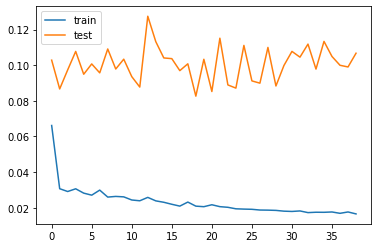

(40, 7)
(40, 7)
(40, 7)
score_train: [119.338] 117.3, 118.0, 129.3, 123.4, 115.2, 116.1, 115.4
(8, 1, 10)
score_test: [319.178] 351.2, 352.9, 61.2, 252.0, 495.0, 287.2, 265.6

RMSE test:  319.17757895478763 

5  	10    	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0628 - val_loss: 0.1039
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1136
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0916
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1132
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1121
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0957
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.090

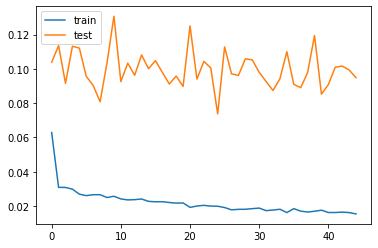

(40, 7)
(40, 7)
(40, 7)
score_train: [115.766] 112.8, 115.6, 126.6, 119.7, 104.3, 114.9, 115.3
(8, 1, 10)
score_test: [300.871] 306.4, 363.1, 59.2, 268.6, 424.7, 314.3, 230.6

RMSE test:  300.8709188095127 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0453 - val_loss: 0.0925
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1109
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.1009
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1095
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.1041
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0957
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1276
Epoch 8/1000
40/40 [=======================

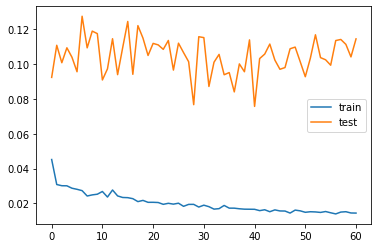

(40, 7)
(40, 7)
(40, 7)
score_train: [112.016] 104.6, 115.8, 124.3, 114.9, 99.8, 113.8, 109.1
(8, 1, 10)
score_test: [330.743] 363.8, 401.9, 96.0, 287.6, 424.0, 320.1, 312.5

RMSE test:  330.74315932008244 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0593 - val_loss: 0.0959
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0999
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0962
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0829
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1047
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0917
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0908
Epoch 8/1000
40/40 [=======================

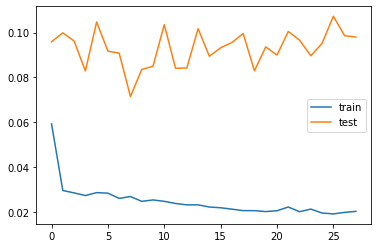

(40, 7)
(40, 7)
(40, 7)
score_train: [125.978] 127.9, 133.4, 133.0, 127.1, 113.6, 121.2, 124.5
(8, 1, 10)
score_test: [305.833] 327.6, 348.1, 56.5, 223.7, 465.6, 304.8, 251.8

RMSE test:  305.83314063255034 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0911
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.1072
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1215
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1007
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1048
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1033
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0969
Epoch 8/1000
40/40 [======================

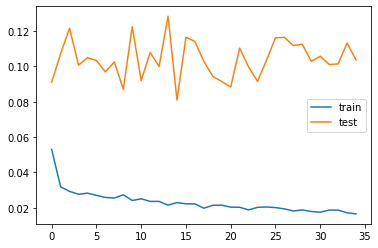

(40, 7)
(40, 7)
(40, 7)
score_train: [121.070] 122.2, 127.4, 129.1, 124.4, 112.0, 115.1, 116.2
(8, 1, 10)
score_test: [314.508] 346.7, 364.9, 69.9, 272.3, 471.7, 283.3, 239.3

RMSE test:  314.5078133731079 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0837
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0922
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0935
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0856
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1000
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0954
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0883
Epoch 8/1000
40/40 [=======================

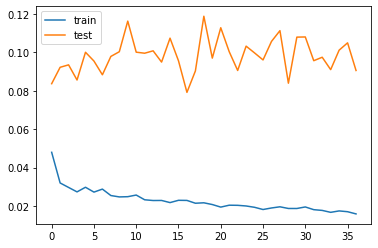

(40, 7)
(40, 7)
(40, 7)
score_train: [119.064] 122.3, 118.2, 127.9, 123.3, 111.8, 115.9, 113.2
(8, 1, 10)
score_test: [293.969] 367.7, 365.2, 60.0, 210.3, 406.2, 260.2, 236.3

RMSE test:  293.9690016357767 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 0.1144
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.1107
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1062
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0973
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1154
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1094
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.1218
Epoch 8/1000
40/40 [=======================

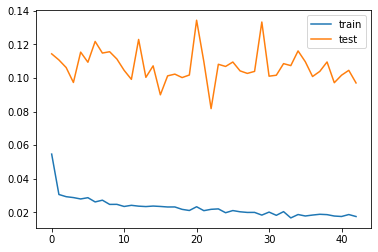

(40, 7)
(40, 7)
(40, 7)
score_train: [118.052] 118.9, 116.7, 127.9, 121.0, 108.7, 117.6, 114.8
(8, 1, 10)
score_test: [304.326] 366.3, 385.0, 34.9, 232.8, 427.4, 261.0, 244.3

RMSE test:  304.3264289344312 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.0495 - val_loss: 0.0859
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0951
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1093
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1013
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1046
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1235
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1041
Epoch 8/1000
40/40 [======================

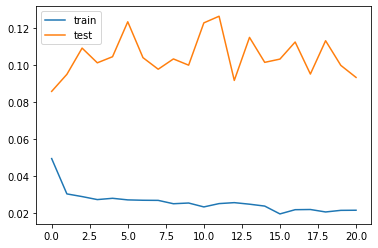

(40, 7)
(40, 7)
(40, 7)
score_train: [132.801] 130.8, 132.0, 139.2, 127.8, 123.4, 134.8, 140.7
(8, 1, 10)
score_test: [298.618] 367.9, 346.3, 73.9, 234.3, 449.9, 255.3, 202.4

RMSE test:  298.6178421812198 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0970
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1207
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1087
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1058
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1089
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0952
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.1074
Epoch 8/1000
40/40 [=======================

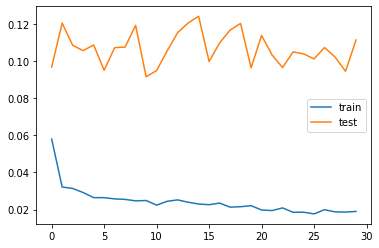

(40, 7)
(40, 7)
(40, 7)
score_train: [123.933] 122.9, 126.6, 132.7, 125.2, 114.6, 121.2, 123.6
(8, 1, 10)
score_test: [326.299] 386.8, 388.1, 71.7, 239.8, 460.3, 290.2, 293.9

RMSE test:  326.2988759608767 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.1169
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0905
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0837
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1112
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0970
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0893
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0874
Epoch 8/1000
40/40 [=======================

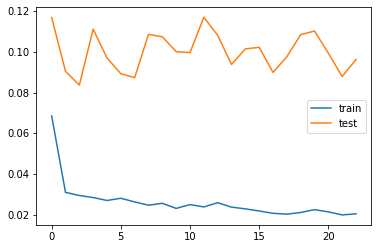

(40, 7)
(40, 7)
(40, 7)
score_train: [132.575] 138.2, 137.8, 138.2, 129.4, 117.0, 131.8, 134.3
(8, 1, 10)
score_test: [303.178] 321.0, 333.7, 56.4, 242.4, 453.1, 289.1, 279.7

RMSE test:  303.17840064240744 

6  	9     	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0869
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1068
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0909
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1067
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0970
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0971
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.109

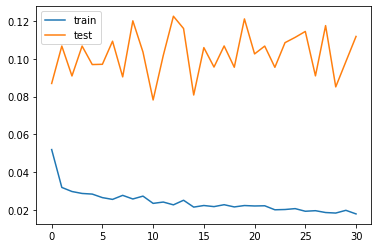

(40, 7)
(40, 7)
(40, 7)
score_train: [125.003] 125.1, 125.9, 131.9, 124.1, 114.8, 127.1, 125.4
(8, 1, 10)
score_test: [326.732] 372.6, 345.7, 33.0, 234.2, 493.0, 340.0, 272.6

RMSE test:  326.73208602415696 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.1064
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.1028
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1132
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0971
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0949
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1046
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1124
Epoch 8/1000
40/40 [======================

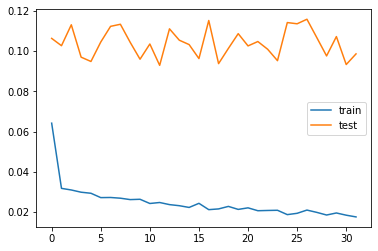

(40, 7)
(40, 7)
(40, 7)
score_train: [123.018] 124.8, 127.2, 130.9, 126.1, 109.7, 118.2, 123.1
(8, 1, 10)
score_test: [306.984] 336.5, 345.4, 27.4, 261.6, 441.6, 294.5, 276.1

RMSE test:  306.983568373073 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.1006
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0798
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0965
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0937
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0931
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0900
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0938
Epoch 8/1000
40/40 [========================

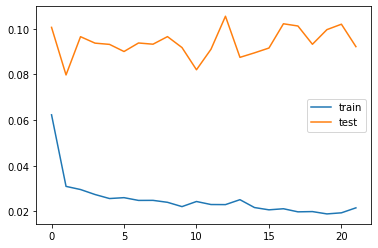

(40, 7)
(40, 7)
(40, 7)
score_train: [129.962] 130.4, 132.5, 138.6, 129.3, 120.2, 127.1, 130.9
(8, 1, 10)
score_test: [296.588] 357.2, 351.5, 43.2, 186.9, 432.5, 275.7, 254.4

RMSE test:  296.58846445661766 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0594 - val_loss: 0.1145
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1001
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0973
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1151
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1087
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.1067
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1034
Epoch 8/1000
40/40 [======================

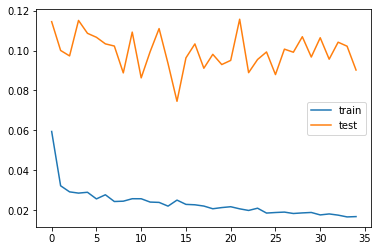

(40, 7)
(40, 7)
(40, 7)
score_train: [122.402] 123.5, 122.7, 129.8, 123.4, 113.1, 124.8, 119.0
(8, 1, 10)
score_test: [293.481] 334.6, 351.9, 21.1, 206.0, 428.7, 272.2, 257.6

RMSE test:  293.4812948293705 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.1286
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0923
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0952
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0946
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1014
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0988
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1147
Epoch 8/1000
40/40 [=======================

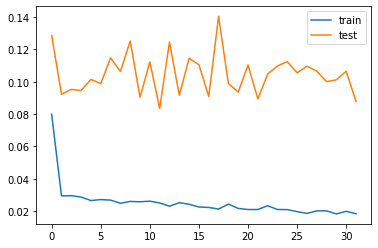

(40, 7)
(40, 7)
(40, 7)
score_train: [124.327] 123.9, 126.1, 134.5, 125.9, 113.3, 121.4, 124.2
(8, 1, 10)
score_test: [289.441] 327.8, 352.2, 57.8, 222.3, 423.6, 276.5, 215.1

RMSE test:  289.44102179579346 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.1085
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0954
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0992
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1018
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.1046
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0848
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0943
Epoch 8/1000
40/40 [======================

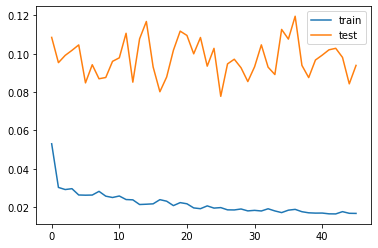

(40, 7)
(40, 7)
(40, 7)
score_train: [116.274] 113.9, 118.4, 126.6, 120.8, 106.8, 115.1, 111.2
(8, 1, 10)
score_test: [299.444] 326.7, 327.4, 22.6, 244.9, 439.6, 325.8, 232.0

RMSE test:  299.4435184705043 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.1043
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1031
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.1056
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1085
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1006
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1160
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0974
Epoch 8/1000
40/40 [=======================

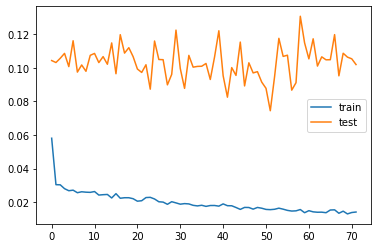

(40, 7)
(40, 7)
(40, 7)
score_train: [105.534] 100.0, 101.6, 118.8, 108.7, 95.1, 110.2, 102.6
(8, 1, 10)
score_test: [311.825] 354.6, 379.8, 61.7, 278.7, 425.7, 303.1, 236.9

RMSE test:  311.82508947423196 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0820
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0912
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1001
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0976
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0928
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1045
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1124
Epoch 8/1000
40/40 [=======================

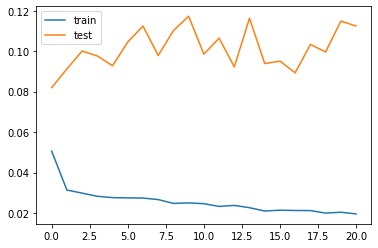

(40, 7)
(40, 7)
(40, 7)
score_train: [130.958] 132.3, 137.9, 136.9, 129.5, 119.0, 124.7, 135.4
(8, 1, 10)
score_test: [327.566] 358.7, 396.4, 48.4, 243.3, 482.4, 314.2, 268.9

RMSE test:  327.56581460488593 

7  	8     	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0647 - val_loss: 0.1103
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0907
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1111
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0920
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1232
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0963
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.106

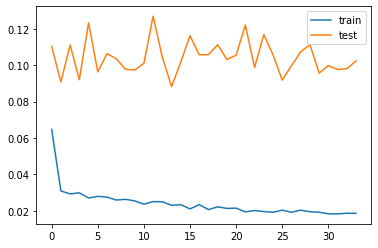

(40, 7)
(40, 7)
(40, 7)
score_train: [121.342] 119.7, 123.4, 130.8, 124.7, 110.4, 120.4, 119.1
(8, 1, 10)
score_test: [312.526] 340.6, 358.4, 58.1, 235.4, 468.9, 327.2, 231.2

RMSE test:  312.52611060628556 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.1040
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0911
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0944
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0906
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0808
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1163
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0885
Epoch 8/1000
40/40 [======================

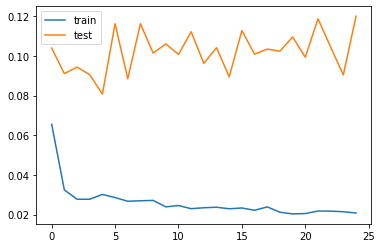

(40, 7)
(40, 7)
(40, 7)
score_train: [133.446] 130.7, 134.1, 137.0, 133.6, 131.8, 131.4, 135.4
(8, 1, 10)
score_test: [338.545] 366.8, 328.2, 46.6, 296.7, 510.7, 351.3, 292.6

RMSE test:  338.54474605728984 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0759
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1041
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1064
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0939
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1013
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0921
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1009
Epoch 8/1000
40/40 [======================

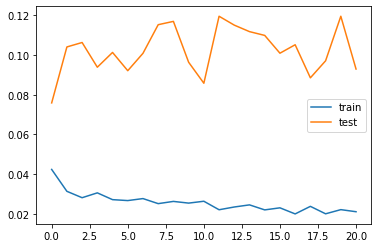

(40, 7)
(40, 7)
(40, 7)
score_train: [131.094] 133.3, 134.3, 137.4, 131.5, 121.0, 128.9, 130.6
(8, 1, 10)
score_test: [297.902] 356.8, 344.8, 54.5, 216.5, 425.3, 299.6, 233.5

RMSE test:  297.90157993118595 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0609 - val_loss: 0.0950
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1009
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0891
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0982
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0996
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1074
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1246
Epoch 8/1000
40/40 [======================

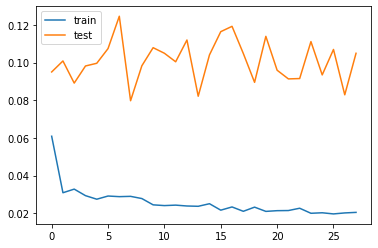

(40, 7)
(40, 7)
(40, 7)
score_train: [130.753] 133.7, 134.3, 138.1, 126.5, 116.0, 131.0, 134.3
(8, 1, 10)
score_test: [316.513] 374.8, 364.0, 31.8, 212.4, 449.6, 316.5, 282.5

RMSE test:  316.51342630416633 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0603 - val_loss: 0.1005
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.1017
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1008
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1007
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1026
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0917
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.1057
Epoch 8/1000
40/40 [======================

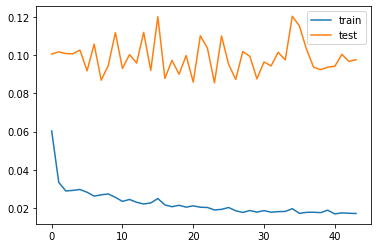

(40, 7)
(40, 7)
(40, 7)
score_train: [116.339] 115.1, 117.0, 128.0, 120.2, 105.8, 116.1, 110.8
(8, 1, 10)
score_test: [305.137] 333.0, 370.6, 56.0, 246.1, 450.5, 269.2, 253.7

RMSE test:  305.1373508185655 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.1161
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1115
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1119
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1064
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1032
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.1113
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.1072
Epoch 8/1000
40/40 [=======================

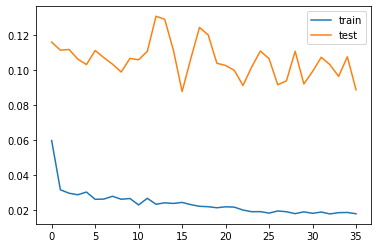

(40, 7)
(40, 7)
(40, 7)
score_train: [121.963] 124.2, 125.9, 128.7, 125.9, 113.7, 119.1, 115.3
(8, 1, 10)
score_test: [291.019] 343.5, 335.3, 43.4, 212.0, 419.8, 283.2, 243.2

RMSE test:  291.01902703426873 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.0470 - val_loss: 0.0850
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.1125
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0951
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0906
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0968
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1020
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1105
Epoch 8/1000
40/40 [=====================

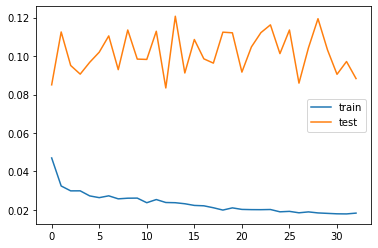

(40, 7)
(40, 7)
(40, 7)
score_train: [124.065] 123.9, 125.9, 134.1, 131.3, 112.1, 118.7, 121.1
(8, 1, 10)
score_test: [290.307] 352.7, 332.0, 42.4, 216.7, 413.9, 297.2, 216.7

RMSE test:  290.30728844048673 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0898
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0981
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0991
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0970
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1071
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0943
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.1188
Epoch 8/1000
40/40 [======================

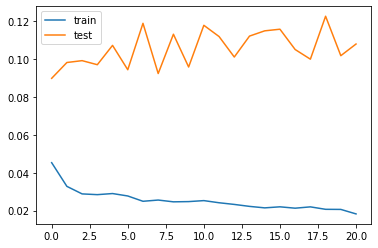

(40, 7)
(40, 7)
(40, 7)
score_train: [131.479] 131.9, 137.3, 136.6, 132.8, 119.2, 128.1, 133.6
(8, 1, 10)
score_test: [320.881] 373.0, 355.9, 56.3, 206.9, 476.0, 319.5, 283.4

RMSE test:  320.88083516777294 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0662 - val_loss: 0.1107
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0859
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0968
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0923
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1094
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0994
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.1051
Epoch 8/1000
40/40 [======================

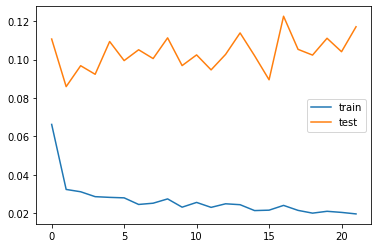

(40, 7)
(40, 7)
(40, 7)
score_train: [133.925] 134.2, 133.1, 141.3, 132.2, 124.2, 134.5, 137.4
(8, 1, 10)
score_test: [334.248] 333.2, 360.1, 61.2, 255.8, 492.7, 362.0, 313.7

RMSE test:  334.24818318313686 

8  	9     	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0826
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1068
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0885
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0892
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0993
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0918
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.104

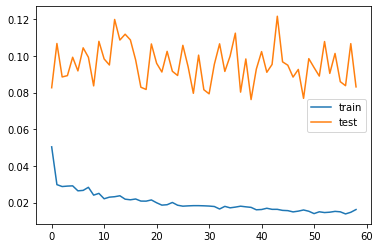

(40, 7)
(40, 7)
(40, 7)
score_train: [108.953] 101.8, 106.1, 121.6, 113.6, 100.0, 110.7, 107.4
(8, 1, 10)
score_test: [281.667] 299.3, 370.0, 54.0, 250.4, 380.1, 245.2, 242.1

RMSE test:  281.6674103822242 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.1011
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0968
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0905
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0995
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0842
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0904
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0986
Epoch 8/1000
40/40 [=======================

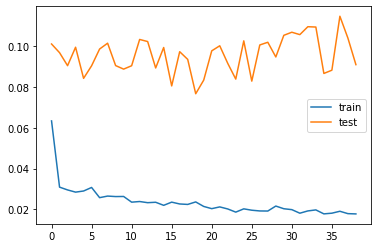

(40, 7)
(40, 7)
(40, 7)
score_train: [120.375] 122.5, 122.2, 127.3, 126.1, 112.4, 116.9, 114.3
(8, 1, 10)
score_test: [294.675] 348.4, 365.4, 47.1, 197.6, 421.2, 286.0, 229.1

RMSE test:  294.67498600952626 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.1103
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1045
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0924
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0940
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0978
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0995
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0835
Epoch 8/1000
40/40 [======================

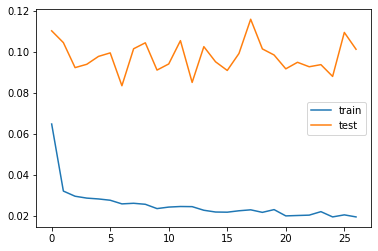

(40, 7)
(40, 7)
(40, 7)
score_train: [127.485] 130.5, 133.5, 134.6, 126.7, 116.0, 124.7, 125.4
(8, 1, 10)
score_test: [310.963] 310.9, 333.2, 31.6, 244.2, 467.8, 329.7, 284.6

RMSE test:  310.9630628505026 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0939
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0828
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0962
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0916
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.1067
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1058
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1144
Epoch 8/1000
40/40 [=======================

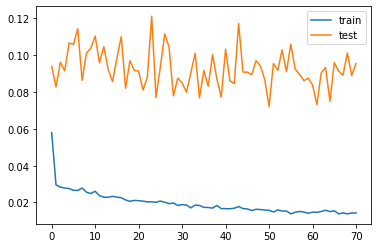

(40, 7)
(40, 7)
(40, 7)
score_train: [106.405] 102.3, 104.9, 116.7, 110.7, 98.1, 109.5, 101.4
(8, 1, 10)
score_test: [301.968] 333.7, 381.1, 51.0, 240.0, 413.2, 314.8, 227.2

RMSE test:  301.967849874082 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0969
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.1007
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1033
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1080
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0964
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1055
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1242
Epoch 8/1000
40/40 [=========================

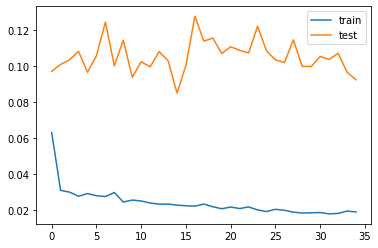

(40, 7)
(40, 7)
(40, 7)
score_train: [122.881] 122.5, 127.0, 129.7, 124.7, 113.0, 123.3, 119.3
(8, 1, 10)
score_test: [296.624] 346.4, 351.6, 48.6, 228.8, 436.6, 274.0, 227.8

RMSE test:  296.6240989833292 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0915
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0897
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0949
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0974
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0890
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0764
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0933
Epoch 8/1000
40/40 [=======================

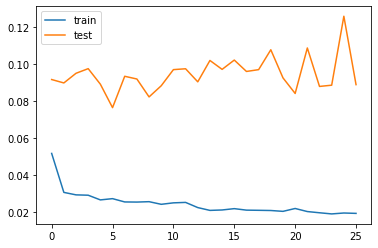

(40, 7)
(40, 7)
(40, 7)
score_train: [126.874] 130.7, 131.7, 133.8, 126.9, 114.4, 124.1, 125.5
(8, 1, 10)
score_test: [291.114] 376.9, 342.9, 28.4, 223.1, 422.8, 241.5, 214.4

RMSE test:  291.11355251847135 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.1128
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0987
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1028
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1009
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1109
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.1062
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1319
Epoch 8/1000
40/40 [======================

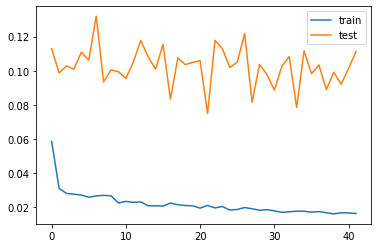

(40, 7)
(40, 7)
(40, 7)
score_train: [118.164] 118.9, 121.0, 127.9, 120.1, 109.2, 115.5, 113.7
(8, 1, 10)
score_test: [325.752] 314.9, 379.2, 63.3, 253.4, 479.4, 335.9, 298.3

RMSE test:  325.75210762037375 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0718
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0947
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1046
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0855
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0874
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0799
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0984
Epoch 8/1000
40/40 [======================

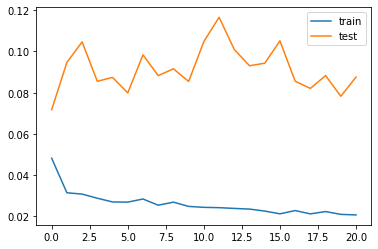

(40, 7)
(40, 7)
(40, 7)
score_train: [131.255] 133.1, 136.5, 137.9, 129.2, 117.8, 129.8, 133.5
(8, 1, 10)
score_test: [289.090] 328.4, 344.1, 48.1, 236.9, 418.6, 269.5, 229.1

RMSE test:  289.0903487450628 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0833
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1107
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0912
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0854
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1031
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1065
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1068
Epoch 8/1000
40/40 [=======================

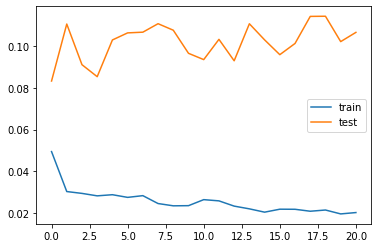

(40, 7)
(40, 7)
(40, 7)
score_train: [130.317] 129.5, 133.8, 136.3, 128.2, 120.9, 129.3, 133.6
(8, 1, 10)
score_test: [319.174] 364.9, 372.0, 50.8, 213.8, 487.6, 307.3, 247.4

RMSE test:  319.1742983759213 

9  	9     	281.295	0       	281.295	281.295

Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 0.1211
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1178
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1008
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1072
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1146
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0959
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1309

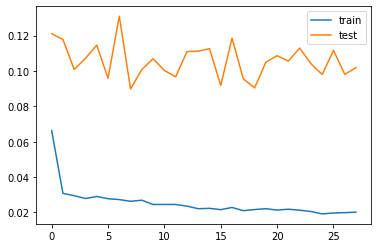

(40, 7)
(40, 7)
(40, 7)
score_train: [128.384] 128.1, 133.5, 134.4, 129.2, 117.1, 124.4, 131.1
(8, 1, 10)
score_test: [311.871] 338.6, 369.4, 39.4, 254.5, 455.2, 309.1, 246.2

RMSE test:  311.8713119771325 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0773
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1020
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1006
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0967
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0936
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1202
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1012
Epoch 8/1000
40/40 [=======================

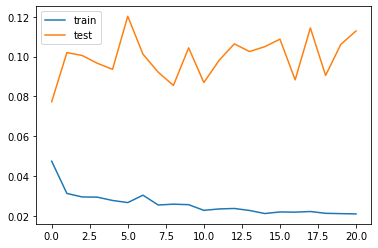

(40, 7)
(40, 7)
(40, 7)
score_train: [132.571] 133.5, 134.6, 138.2, 133.4, 120.9, 131.6, 135.0
(8, 1, 10)
score_test: [328.199] 364.2, 328.0, 25.2, 263.5, 494.7, 335.9, 293.5

RMSE test:  328.19893600286264 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0798
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1024
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0986
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0866
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0999
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0986
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0962
Epoch 8/1000
40/40 [======================

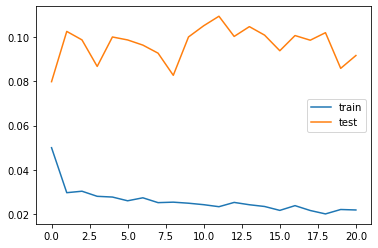

(40, 7)
(40, 7)
(40, 7)
score_train: [132.317] 134.0, 135.5, 138.6, 129.3, 121.8, 129.5, 136.7
(8, 1, 10)
score_test: [295.610] 329.8, 336.1, 26.2, 243.2, 437.2, 294.4, 228.7

RMSE test:  295.60967392049815 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.1118
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1031
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1123
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0988
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1080
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1046
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0934
Epoch 8/1000
40/40 [======================

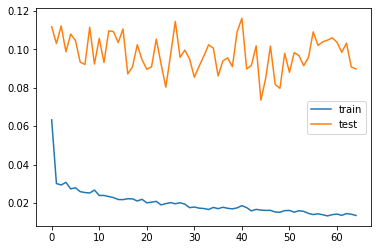

(40, 7)
(40, 7)
(40, 7)
score_train: [106.769] 97.2, 100.2, 119.1, 114.1, 102.7, 109.8, 102.5
(8, 1, 10)
score_test: [292.884] 320.9, 393.7, 68.6, 257.1, 365.2, 288.4, 234.7

RMSE test:  292.88403049426086 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0685
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.1008
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0949
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0852
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0867
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1112
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0863
Epoch 8/1000
40/40 [=======================

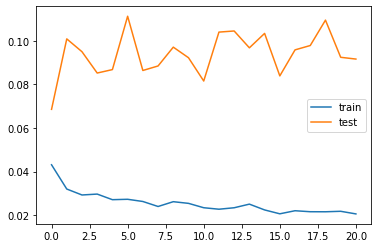

(40, 7)
(40, 7)
(40, 7)
score_train: [131.609] 132.8, 138.1, 138.5, 129.6, 117.1, 130.3, 133.8
(8, 1, 10)
score_test: [295.644] 333.6, 362.7, 52.3, 214.8, 428.9, 274.5, 246.7

RMSE test:  295.64449015522905 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0477 - val_loss: 0.0908
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0995
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0976
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1053
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0934
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1012
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0904
Epoch 8/1000
40/40 [=====================

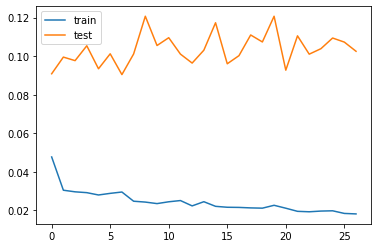

(40, 7)
(40, 7)
(40, 7)
score_train: [125.987] 128.9, 129.4, 133.2, 126.7, 116.2, 124.3, 122.5
(8, 1, 10)
score_test: [312.785] 372.6, 344.5, 42.6, 209.4, 460.8, 330.9, 244.7

RMSE test:  312.78519331335355 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0807
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0931
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0982
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1139
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0969
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0922
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0955
Epoch 8/1000
40/40 [======================

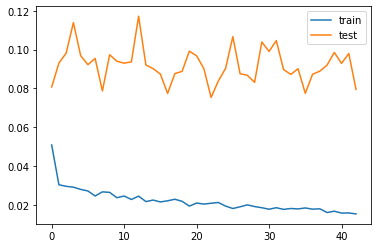

(40, 7)
(40, 7)
(40, 7)
score_train: [118.115] 119.0, 120.2, 125.8, 120.2, 105.6, 123.1, 111.7
(8, 1, 10)
score_test: [275.451] 288.4, 347.2, 38.5, 236.4, 399.8, 257.0, 210.2

RMSE test:  275.4514062963221 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0464 - val_loss: 0.1067
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1005
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1014
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1059
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1162
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0906
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1079
Epoch 8/1000
40/40 [=======================

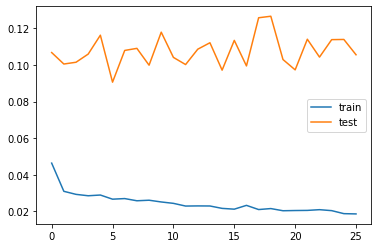

(40, 7)
(40, 7)
(40, 7)
score_train: [126.354] 126.8, 133.3, 134.0, 126.5, 117.0, 123.1, 123.1
(8, 1, 10)
score_test: [317.380] 371.4, 349.9, 40.9, 263.1, 456.6, 310.5, 262.7

RMSE test:  317.37954165494614 


Units CNN1:  255 ,Sequence size:  2
(40, 1, 10)
Epoch 1/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0793
Epoch 2/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0888
Epoch 3/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0979
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0766
Epoch 5/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0885
Epoch 6/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0910
Epoch 7/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0969
Epoch 8/1000
40/40 [======================

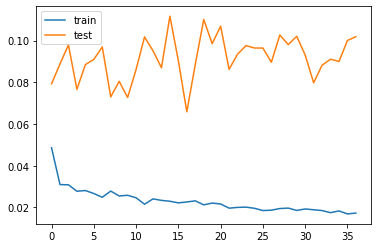

(40, 7)
(40, 7)
(40, 7)
score_train: [120.064] 120.7, 121.2, 128.2, 120.8, 111.0, 120.1, 117.9
(8, 1, 10)
score_test: [311.805] 334.9, 367.2, 34.8, 243.9, 450.3, 294.0, 289.2

RMSE test:  311.8046494813434 

10 	9     	279.542	2.6778  	275.451	281.295


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 275.4514062963221


In [78]:
model=model_name
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 1, 255)            5355      
_________________________________________________________________
flatten_96 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 7)                 1792      
Total params: 7,147
Trainable params: 7,147
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7]])
yhat.shape 

(2, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:14]
test_res['real']=y_test_true.flatten()[0:14]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-08-02,789.331726,693.000000
2020-08-03,693.697632,522.000000
2020-08-04,615.777893,659.000000
2020-08-05,830.429749,1021.000061
2020-08-06,966.167236,1283.000000
2020-08-07,822.421692,1144.000000
2020-08-08,792.381897,1017.999939
2020-08-09,948.648560,1345.000000
2020-08-10,770.030579,1230.000000


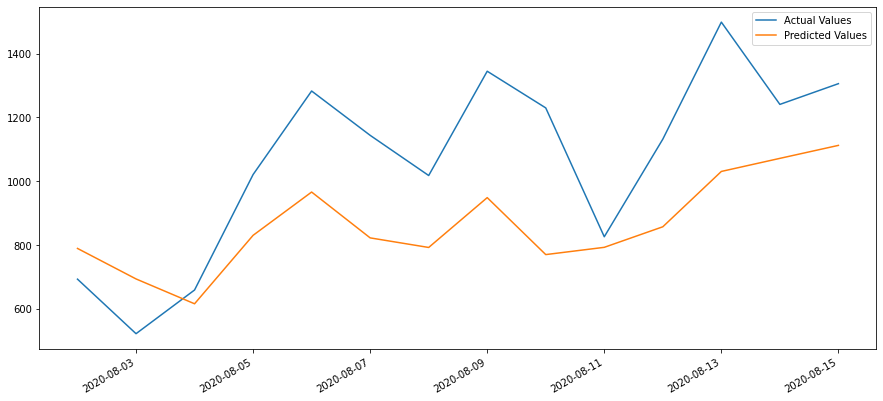

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 75873.48
RMSE: 275.45
MAE: 240.08
R Squared: 0.03
Max Error: 468.22


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(40, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(40, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([725.7738 , 775.4002 , 803.5188 , 806.56476, 769.9036 , 796.3512 ,
       792.65936], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105]
filter_indices = [0,7,14,21,28]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(40, 1, 10)

In [96]:
date_train.head(7)

23033   2020-06-15
23034   2020-06-16
23035   2020-06-17
23036   2020-06-18
23037   2020-06-19
23038   2020-06-20
23039   2020-06-21
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

46

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(35,)

In [101]:
Y_train_real.shape

(35,)

In [102]:
date_train.shape

(48,)

In [103]:
date_train[nb_seq:].shape

(46,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-11

In [105]:
Y_train_real[:-suite_size].shape

(11,)

In [106]:
date_train[nb_seq:].shape

(46,)

In [107]:
Y_train_pred[:-suite_size].shape

(11,)

In [108]:
Y_train_real[:-suite_size].shape

(11,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(35,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-06-17,598.285034,725.773804
2020-06-18,591.851379,775.400208
2020-06-19,592.770508,803.518799
2020-06-20,1017.393250,806.564758
2020-06-21,694.790222,769.903625
2020-06-22,683.761047,796.351196
2020-06-23,701.223877,792.659363
2020-06-24,606.556946,779.702820
2020-06-25,1112.979248,823.184204


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-12,718.686768,692.584534
2020-07-13,708.576721,715.986267
2020-07-14,697.547546,763.555176
2020-07-15,669.974609,764.745850
2020-07-16,673.651062,804.261108
2020-07-17,670.893738,814.364807
2020-07-18,799.567261,827.952026
2020-07-19,787.619019,873.279968
2020-07-20,725.120483,965.777954


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

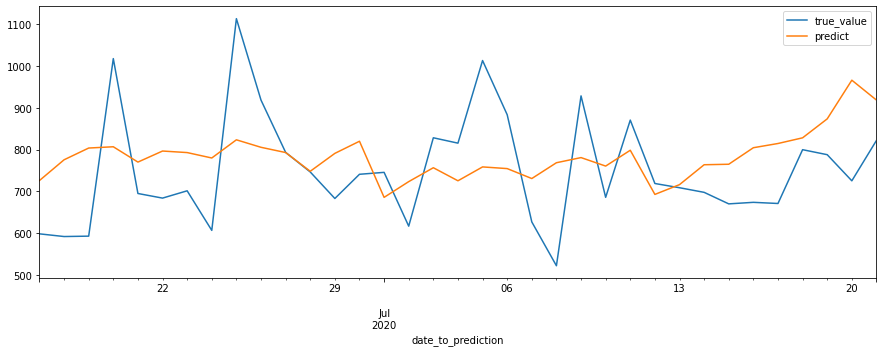

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 13951.23
RMSE 118.12
MAE 93.91
R2 0.58
maxError 334.30
